In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint as torch_checkpoint
import random
from typing import List, Tuple
import numpy as np
from pathlib import Path
from tqdm import tqdm
import sys
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
from torch.utils.tensorboard import SummaryWriter

## DrumSampleDataset Class

In [2]:
class DrumSampleDataset(Dataset):
    def __init__(self,
                 audio_dir: str,
                 hr_segment_length: int = 88200,  # 2 seconds at 44.1kHz
                 lr_segment_length: int = 44100,  # 2 seconds at 22.05kHz
                 hr_sample_rate: int = 44100,
                 lr_sample_rate: int = 22050):
        print("Initializing DrumSampleDataset...")
        self.audio_dir = Path(audio_dir)
        self.hr_segment_length = hr_segment_length
        self.lr_segment_length = lr_segment_length
        self.hr_sample_rate = hr_sample_rate
        self.lr_sample_rate = lr_sample_rate

        self.audio_files = list(self.audio_dir.glob("*.wav"))
        print(f"Found {len(self.audio_files)} audio files.")
        assert len(self.audio_files) > 0, "No .wav files found in the specified directory."

        # Initialize resampler for creating LR version
        self.downsample = torchaudio.transforms.Resample(
            self.hr_sample_rate, self.lr_sample_rate
        )

    def __len__(self) -> int:
        return len(self.audio_files)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        file_path = self.audio_files[idx]
        lr_audio, hr_audio = self.load_and_process_audio(file_path)
        return lr_audio, hr_audio

    def load_and_process_audio(self, file_path: Path) -> Tuple[torch.Tensor, torch.Tensor]:
        waveform, sample_rate = torchaudio.load(file_path)
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
            print(f"Converted to mono: {waveform.shape}")

        # Resample if sample rates do not match
        if sample_rate != self.hr_sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.hr_sample_rate)
            waveform = resampler(waveform)

        # Pad or trim HR audio to 2 seconds
        if waveform.shape[1] < self.hr_segment_length:
            pad_length = self.hr_segment_length - waveform.shape[1]
            waveform = F.pad(waveform, (0, pad_length))
        elif waveform.shape[1] > self.hr_segment_length:
            waveform = waveform[:, :self.hr_segment_length]

        # Downsample original audio to 22.05kHz
        lr_audio = self.downsample(waveform)

        # Pad or trim LR audio to 2 seconds
        if lr_audio.shape[1] < self.lr_segment_length:
            pad_length = self.lr_segment_length - lr_audio.shape[1]
            lr_audio = F.pad(lr_audio, (0, pad_length))
        elif lr_audio.shape[1] > self.lr_segment_length:
            lr_audio = lr_audio[:, :self.lr_segment_length]

        # Normalize
        hr_audio = waveform / (torch.max(torch.abs(waveform)) + 1e-7)
        lr_audio = lr_audio / (torch.max(torch.abs(lr_audio)) + 1e-7)

        return lr_audio, hr_audio

## Dataloaders

In [3]:
def create_dataloaders(
    audio_dir: str,
    batch_size: int = 32,
    train_split: float = 0.8,
    num_workers: int = 4
) -> Tuple[DataLoader, DataLoader]:
    print("Creating dataloaders...")
    dataset = DrumSampleDataset(audio_dir)

    indices = list(range(len(dataset)))
    random.shuffle(indices)
    split = int(train_split * len(dataset))
    train_indices = indices[:split]
    val_indices = indices[split:]
    print(f"Split dataset: {len(train_indices)} training files, {len(val_indices)} validation files.")

    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        pin_memory=True
    )
    val_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=val_sampler,
        num_workers=num_workers,
        pin_memory=True
    )

    print("Dataloaders created.")
    return train_loader, val_loader

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        def forward_fn(input):
            out = self.leaky_relu(self.conv1(input))
            out = self.conv2(out)
            return out

        return x + torch_checkpoint(forward_fn, x)

## Custom Frequency-based L1 Loss Function

In [5]:
class FrequencyAwareSpectralLoss(nn.Module):
    def __init__(self, n_fft=2048, hop_length=512):
        super(FrequencyAwareSpectralLoss, self).__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length

        self.sub_weight = nn.Parameter(torch.ones(1))
        self.low_weight = nn.Parameter(torch.ones(1))
        self.mid_weight = nn.Parameter(torch.ones(1))
        self.high_weight = nn.Parameter(torch.ones(1))

    def get_positive_weights(self):
        # Use softplus to ensure weights are always positive
        return {
            'sub': F.softplus(self.sub_weight) * 0.1,  # Reduced weight for sub-bass
            'low': F.softplus(self.low_weight),
            'mid': F.softplus(self.mid_weight) * 1.5,  # Increased weight for mids
            'high': F.softplus(self.high_weight) * 2.0  # Increased weight for highs
        }

    def forward(self, x, y):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        if y.dim() == 2:
            y = y.unsqueeze(1)

        weights = self.get_positive_weights()

        # Pad if necessary
        pad_length = max(0, self.n_fft // 2 - x.shape[-1] % (self.n_fft // 2))
        if pad_length > 0:
            x = F.pad(x, (0, pad_length))
            y = F.pad(y, (0, pad_length))

        # Compute STFTs
        window = torch.hann_window(self.n_fft).to(x.device)
        x_spec = torch.stft(
            x.squeeze(1), n_fft=self.n_fft, hop_length=self.hop_length,
            window=window, return_complex=True
        )
        y_spec = torch.stft(
            y.squeeze(1), n_fft=self.n_fft, hop_length=self.hop_length,
            window=window, return_complex=True
        )

        # Compute magnitude spectrograms
        x_mag = torch.abs(x_spec)
        y_mag = torch.abs(y_spec)

        # Define frequency band indices
        sub_idx = self.n_fft // 64    # 0-100 Hz
        low_idx = self.n_fft // 16    # 100-400 Hz
        mid_idx = self.n_fft // 4     # 400-2000 Hz

        # band-specific losses
        sub_loss = weights['sub'] * F.l1_loss(
            x_mag[:, :sub_idx, :],
            y_mag[:, :sub_idx, :]
        )

        low_loss = weights['low'] * F.l1_loss(
            x_mag[:, sub_idx:low_idx, :],
            y_mag[:, sub_idx:low_idx, :]
        )

        mid_loss = weights['mid'] * F.l1_loss(
            x_mag[:, low_idx:mid_idx, :],
            y_mag[:, low_idx:mid_idx, :]
        )

        high_loss = weights['high'] * F.l1_loss(
            x_mag[:, mid_idx:, :],
            y_mag[:, mid_idx:, :]
        )

        total_loss = sub_loss + low_loss + mid_loss + high_loss + 1e-8

        return total_loss

## Frequency-Aware Upsampling Model

In [6]:
class FrequencyAwareUpsampling(nn.Module):
    def __init__(self):
        super(FrequencyAwareUpsampling, self).__init__()

        # Sub-bass suppression branch
        self.sub_suppress = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=101, padding=50),
            nn.LeakyReLU(0.2),
            nn.Conv1d(32, 1, kernel_size=101, padding=50),
            nn.Sigmoid()  # Output scaling factor for sub frequencies
        )

        # Time domain branch
        self.time_branch = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=15, stride=1, padding=7),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, kernel_size=41, stride=2, padding=20),
            nn.LeakyReLU(0.2)
        )

        self.spec_branch = SpectralProcessor()

        # Modified fusion path with frequency-aware processing
        self.fusion = nn.Sequential(
            nn.Conv1d(128 + (128 * 64), 512, kernel_size=7, padding=3),
            nn.LeakyReLU(0.2),
            ResidualBlock(512),
            ResidualBlock(512),
            nn.ConvTranspose1d(512, 256, kernel_size=41, stride=2, padding=20, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(256, 1, kernel_size=15, stride=1, padding=7),
            nn.Tanh()
        )

        # High-frequency enhancement branch
        self.high_enhance = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=31, padding=15),
            nn.LeakyReLU(0.2),
            nn.Conv1d(32, 1, kernel_size=31, padding=15),
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)

        sub_mask = self.sub_suppress(x)
        x = x * sub_mask

        time_features = self.time_branch(x)
        spec_features = self.spec_branch(x)

        # Align dimensions
        time_length = time_features.shape[-1]
        spec_features = F.interpolate(
            spec_features,
            size=time_length,
            mode='linear',
            align_corners=False
        )

        # Fusion and upsampling
        fused_features = torch.cat([time_features, spec_features], dim=1)
        output = self.fusion(fused_features)

        # High frequency enhancement
        high_mask = self.high_enhance(output)
        output = output * high_mask  # Apply high-frequency enhancement

        # Final upsampling to target length
        target_length = 88200  # 2 seconds at 44.1kHz
        output = F.interpolate(
            output,
            size=target_length,
            mode='linear',
            align_corners=False
        )

        return output

## Frequency Band Split

In [7]:
class FrequencyBandSplit(nn.Module):
    def __init__(self):
        super(FrequencyBandSplit, self).__init__()
        self.sub_attention = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.Sigmoid()
        )
        self.high_attention = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        sub_mask = self.sub_attention(x)
        high_mask = self.high_attention(x)

        # Create frequency band masks
        freq_bins = x.shape[2]
        sub_range = slice(None, freq_bins//8)
        high_range = slice(freq_bins//2, None)

        # Initialize a ones tensor for the middle frequencies
        mid_mask = torch.ones_like(x)

        # Apply different attentions to different frequency ranges
        x = x * (1 - sub_mask)  # Suppress sub frequencies
        x = x * torch.where(
            torch.arange(freq_bins, device=x.device).view(1, 1, -1, 1) >= freq_bins//2,
            high_mask,
            mid_mask
        )

        return x

class SpectralProcessor(nn.Module):
    def __init__(self, n_fft=1024, hop_length=256):
        super(SpectralProcessor, self).__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length

        self.spec_encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.2),
            FrequencyBandSplit(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.2),
            # Move the frequency reduction after all processing
            nn.AdaptiveAvgPool2d((64, None))  # Reduce frequency bins to 64
        )

    def forward(self, x):
        # Pad inputs if necessary
        pad_length = max(0, self.n_fft // 2 - x.shape[-1] % (self.n_fft // 2))
        if pad_length > 0:
            x = F.pad(x, (0, pad_length))

        # Compute STFT
        window = torch.hann_window(self.n_fft).to(x.device)
        spec = torch.stft(
            x.squeeze(1), n_fft=self.n_fft, hop_length=self.hop_length,
            window=window, return_complex=True
        )

        # Magnitude and phase
        mag = torch.log1p(torch.abs(spec))
        phase = torch.angle(spec)
        spec_input = torch.stack([mag, phase], dim=1)  # [batch, 2, freq_bins, time_steps]

        # Process spectral features
        spec_features = self.spec_encoder(spec_input)  # [batch, 128, 64, time_steps]

        # Flatten frequency bins and channels
        batch_size, channels, freq_bins, time_steps = spec_features.shape
        return spec_features.view(batch_size, channels * freq_bins, time_steps)

## Training

In [8]:
def calculate_snr(output, target):
    """Calculate Signal-to-Noise Ratio in decibels"""
    noise = target - output
    signal_power = torch.mean(target ** 2)
    noise_power = torch.mean(noise ** 2)
    snr = 10 * torch.log10(signal_power / (noise_power + 1e-10))
    return snr.item()

def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs,
    device,
    checkpoint_dir: str = "checkpoints",
    save_frequency: int = 1,
    initial_lr: float = 0.0001,
    max_grad_norm: float = 1.0,
    weight_decay: float = 1e-6,
    early_stopping_patience: int = 20,
    disable_pbar: bool = False
):
    print("Starting training...")
    writer = SummaryWriter('runs/experiment_name')

    time_criterion = nn.L1Loss()
    spectral_criterion = FrequencyAwareSpectralLoss().to(device)

    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(spectral_criterion.parameters()),
        lr=initial_lr,
        weight_decay=weight_decay
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )

    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    best_val_loss = float('inf')
    patience_counter = 0
    history = defaultdict(list)

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()
        train_losses = []
        train_snrs = []
        train_mse = []

        with tqdm(total=len(train_loader),
                 desc=f'Epoch {epoch+1}/{num_epochs}',
                 leave=True,
                 disable=disable_pbar,
                 dynamic_ncols=True) as pbar:
            for lr_audio, hr_audio in train_loader:
                lr_audio, hr_audio = lr_audio.to(device), hr_audio.to(device)
                optimizer.zero_grad()

                output = model(lr_audio)
                time_loss = time_criterion(output, hr_audio)
                spec_loss = spectral_criterion(output, hr_audio)

                spec_weight = min(1.0, epoch / 10)
                total_loss = time_loss + spec_weight * spec_loss

                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Calculate metrics
                with torch.no_grad():
                    snr = calculate_snr(output, hr_audio)
                    mse = F.mse_loss(output, hr_audio).item()

                train_losses.append(total_loss.item())
                train_snrs.append(snr)
                train_mse.append(mse)

                pbar.set_postfix({
                    'loss': f'{total_loss.item():.4f}',
                    'SNR': f'{snr:.2f}dB'
                })
                pbar.update(1)

        # Calculate average training metrics
        epoch_train_loss = np.mean(train_losses)
        epoch_train_snr = np.mean(train_snrs)
        epoch_train_mse = np.mean(train_mse)

        history['train_loss'].append(epoch_train_loss)
        history['train_snr'].append(epoch_train_snr)
        history['train_mse'].append(epoch_train_mse)

        writer.add_scalar('Loss/train', epoch_train_loss, epoch)
        writer.add_scalar('SNR/train', epoch_train_snr, epoch)
        writer.add_scalar('MSE/train', epoch_train_mse, epoch)

        # Validation phase
        model.eval()
        val_losses = []
        val_snrs = []
        val_mse = []

        with torch.no_grad():
            for lr_audio, hr_audio in val_loader:
                lr_audio, hr_audio = lr_audio.to(device), hr_audio.to(device)
                output = model(lr_audio)
                time_loss = time_criterion(output, hr_audio)
                spec_loss = spectral_criterion(output, hr_audio)
                batch_val_loss = (time_loss + 0.5 * spec_loss).item()

                # Calculate validation metrics
                snr = calculate_snr(output, hr_audio)
                mse = F.mse_loss(output, hr_audio).item()

                val_losses.append(batch_val_loss)
                val_snrs.append(snr)
                val_mse.append(mse)

        epoch_val_loss = np.mean(val_losses)
        epoch_val_snr = np.mean(val_snrs)
        epoch_val_mse = np.mean(val_mse)

        history['val_loss'].append(epoch_val_loss)
        history['val_snr'].append(epoch_val_snr)
        history['val_mse'].append(epoch_val_mse)

        writer.add_scalar('Loss/val', epoch_val_loss, epoch)
        writer.add_scalar('SNR/val', epoch_val_snr, epoch)
        writer.add_scalar('MSE/val', epoch_val_mse, epoch)

        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {epoch_train_loss:.4f}, SNR: {epoch_train_snr:.2f}dB, MSE: {epoch_train_mse:.6f}, "
                  f"Val Loss: {epoch_val_loss:.4f}, SNR: {epoch_val_snr:.2f}dB, MSE: {epoch_val_mse:.6f}, "
                  f"LR: {current_lr:.2e}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            checkpoint_path = Path(checkpoint_dir) / "best_model.pth"
            save_checkpoint(
                model, optimizer, scheduler, epoch,
                epoch_train_loss, epoch_val_loss, checkpoint_path,
                metrics={'snr': epoch_val_snr, 'mse': epoch_val_mse}
            )
            print(f"New best model saved (val_loss: {epoch_val_loss:.4f}, SNR: {epoch_val_snr:.2f}dB)")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

        if (epoch + 1) % save_frequency == 0:
            checkpoint_path = Path(checkpoint_dir) / f"checkpoint_epoch_{epoch+1}.pth"
            save_checkpoint(
                model, optimizer, scheduler, epoch,
                epoch_train_loss, epoch_val_loss, checkpoint_path,
                metrics={'snr': epoch_val_snr, 'mse': epoch_val_mse}
            )

    return model, history

In [9]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, filepath, metrics=None):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    if metrics is not None:
        checkpoint.update(metrics)

    torch.save(checkpoint, filepath)

def load_checkpoint(model, checkpoint_path, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    metrics = {}
    for key in ['snr', 'mse']:
        if key in checkpoint:
            metrics[key] = checkpoint[key]

    return model, checkpoint, metrics

## Inference

In [10]:
def inference(
    model: nn.Module,
    input_file: str,
    output_file: str,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> None:
    """
    Perform inference on an audio file to create a high-resolution version.
    """
    # Load and process input audio
    lr_audio = load_for_inference(input_file)

    model.eval()

    model = model.to(device)
    lr_audio = lr_audio.to(device)

    with torch.no_grad():
        chunk_size = 44100  # 2 seconds at 22.05kHz
        output_chunks = []

        for i in range(0, lr_audio.shape[1], chunk_size):
            chunk = lr_audio[:, i:i + chunk_size]

            # Pad if necessary
            if chunk.shape[1] < chunk_size:
                pad_length = chunk_size - chunk.shape[1]
                chunk = F.pad(chunk, (0, pad_length))

            if chunk.dim() == 2:
                chunk = chunk.unsqueeze(0)  # Add batch dimension if needed

            output_chunk = model(chunk)

            if i + chunk_size > lr_audio.shape[1] and pad_length > 0:
                samples_to_remove = pad_length * 2  # multiply by 2 for 44.1kHz
                output_chunk = output_chunk[:, :, :-samples_to_remove]

            output_chunks.append(output_chunk.cpu())

        # Concatenate chunks
        final_output = torch.cat(output_chunks, dim=2)

        expected_length = lr_audio.shape[1] * 2
        if final_output.shape[2] != expected_length:
            final_output = F.interpolate(
                final_output,
                size=expected_length,
                mode='linear',
                align_corners=False
            )

        # Normalize
        final_output = final_output / torch.max(torch.abs(final_output))

        final_output = final_output.cpu().squeeze(0)
        lr_audio = lr_audio.cpu().squeeze(0)

        import soundfile as sf
        sf.write(output_file, final_output.numpy().T, 44100, 'PCM_16')
        sf.write("original_audio_lr.wav", lr_audio.numpy().T, 22050, 'PCM_16')
        print("Successfully saved using soundfile")

def load_for_inference(
    file_path: str,
    hr_sample_rate: int = 44100,
    lr_sample_rate: int = 22050
) -> torch.Tensor:
    downsample = torchaudio.transforms.Resample(hr_sample_rate, lr_sample_rate)

    # Load audio
    waveform, sample_rate = torchaudio.load(file_path)

    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Resample if necessary
    if sample_rate != hr_sample_rate:
        resampler = torchaudio.transforms.Resample(sample_rate, hr_sample_rate)
        waveform = resampler(waveform)

    # Create low-resolution version (22.05kHz)
    lr_audio = downsample(waveform)

    # Normalize
    lr_audio = lr_audio / (torch.max(torch.abs(lr_audio)) + 1e-7)

    return lr_audio

In [ ]:
def plot_metrics(history, save_path=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot losses
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot SNR
    ax2.plot(epochs, history['train_snr'], 'b-', label='Training SNR')
    ax2.plot(epochs, history['val_snr'], 'r-', label='Validation SNR')
    ax2.set_title('Signal-to-Noise Ratio')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('SNR (dB)')
    ax2.legend()
    ax2.grid(True)

    # Plot MSE
    ax3.plot(epochs, history['train_mse'], 'b-', label='Training MSE')
    ax3.plot(epochs, history['val_mse'], 'r-', label='Validation MSE')
    ax3.set_title('Mean Squared Error')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MSE')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

    plt.show()

In [ ]:
def plot_losses(history, save_path=None):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot training loss
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')

    # Plot validation loss
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

    plt.show()

Creating dataloaders...
Initializing DrumSampleDataset...
Found 5844 audio files.
Split dataset: 4675 training files, 1169 validation files.
Dataloaders created.
Total parameters: 38802211
Trainable parameters: 38802211
sub_suppress.0: requires_grad = True
sub_suppress.2: requires_grad = True
time_branch.0: requires_grad = True
time_branch.2: requires_grad = True
fusion.0: requires_grad = True
fusion.2.conv1: requires_grad = True
fusion.2.conv2: requires_grad = True
fusion.3.conv1: requires_grad = True
fusion.3.conv2: requires_grad = True
fusion.4: requires_grad = True
fusion.6: requires_grad = True
high_enhance.0: requires_grad = True
high_enhance.2: requires_grad = True
Starting training...


Epoch 1/100: 100%|██████████| 585/585 [07:09<00:00,  1.36it/s, loss=0.0040, SNR=12.33dB]


Epoch [1/100] - Train Loss: 0.0061, SNR: 10.01dB, MSE: 0.000903, Val Loss: 0.1195, SNR: 14.93dB, MSE: 0.000122, LR: 1.00e-04
New best model saved (val_loss: 0.1195, SNR: 14.93dB)


Epoch 2/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0135, SNR=16.64dB]


Epoch [2/100] - Train Loss: 0.0130, SNR: 18.64dB, MSE: 0.000060, Val Loss: 0.0402, SNR: 20.22dB, MSE: 0.000039, LR: 1.00e-04
New best model saved (val_loss: 0.0402, SNR: 20.22dB)


Epoch 3/100: 100%|██████████| 585/585 [06:18<00:00,  1.54it/s, loss=0.0149, SNR=19.94dB]


Epoch [3/100] - Train Loss: 0.0155, SNR: 20.75dB, MSE: 0.000036, Val Loss: 0.0324, SNR: 21.38dB, MSE: 0.000031, LR: 1.00e-04
New best model saved (val_loss: 0.0324, SNR: 21.38dB)


Epoch 4/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0160, SNR=21.57dB]


Epoch [4/100] - Train Loss: 0.0187, SNR: 22.33dB, MSE: 0.000026, Val Loss: 0.0287, SNR: 23.18dB, MSE: 0.000020, LR: 1.00e-04
New best model saved (val_loss: 0.0287, SNR: 23.18dB)


Epoch 5/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0192, SNR=22.58dB]


Epoch [5/100] - Train Loss: 0.0202, SNR: 24.14dB, MSE: 0.000017, Val Loss: 0.0221, SNR: 24.21dB, MSE: 0.000015, LR: 1.00e-04
New best model saved (val_loss: 0.0221, SNR: 24.21dB)


Epoch 6/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0189, SNR=27.27dB]


Epoch [6/100] - Train Loss: 0.0213, SNR: 25.36dB, MSE: 0.000013, Val Loss: 0.0201, SNR: 25.42dB, MSE: 0.000011, LR: 1.00e-04
New best model saved (val_loss: 0.0201, SNR: 25.42dB)


Epoch 7/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0194, SNR=27.60dB]


Epoch [7/100] - Train Loss: 0.0226, SNR: 26.36dB, MSE: 0.000010, Val Loss: 0.0182, SNR: 26.79dB, MSE: 0.000008, LR: 1.00e-04
New best model saved (val_loss: 0.0182, SNR: 26.79dB)


Epoch 8/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0176, SNR=25.19dB]


Epoch [8/100] - Train Loss: 0.0233, SNR: 27.09dB, MSE: 0.000009, Val Loss: 0.0167, SNR: 27.43dB, MSE: 0.000008, LR: 1.00e-04
New best model saved (val_loss: 0.0167, SNR: 27.43dB)


Epoch 9/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0176, SNR=29.43dB]


Epoch [9/100] - Train Loss: 0.0245, SNR: 27.57dB, MSE: 0.000008, Val Loss: 0.0145, SNR: 28.14dB, MSE: 0.000006, LR: 1.00e-04
New best model saved (val_loss: 0.0145, SNR: 28.14dB)


Epoch 10/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0138, SNR=32.99dB]


Epoch [10/100] - Train Loss: 0.0257, SNR: 28.01dB, MSE: 0.000007, Val Loss: 0.0152, SNR: 27.56dB, MSE: 0.000007, LR: 1.00e-04


Epoch 11/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0212, SNR=26.88dB]


Epoch [11/100] - Train Loss: 0.0260, SNR: 28.47dB, MSE: 0.000006, Val Loss: 0.0128, SNR: 27.86dB, MSE: 0.000007, LR: 1.00e-04
New best model saved (val_loss: 0.0128, SNR: 27.86dB)


Epoch 12/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0291, SNR=26.68dB]


Epoch [12/100] - Train Loss: 0.0245, SNR: 28.68dB, MSE: 0.000006, Val Loss: 0.0135, SNR: 27.06dB, MSE: 0.000008, LR: 1.00e-04


Epoch 13/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0124, SNR=38.32dB]


Epoch [13/100] - Train Loss: 0.0231, SNR: 28.82dB, MSE: 0.000006, Val Loss: 0.0128, SNR: 28.06dB, MSE: 0.000006, LR: 1.00e-04


Epoch 14/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0388, SNR=23.78dB]


Epoch [14/100] - Train Loss: 0.0219, SNR: 28.90dB, MSE: 0.000006, Val Loss: 0.0119, SNR: 28.85dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0119, SNR: 28.85dB)


Epoch 15/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0217, SNR=29.76dB]


Epoch [15/100] - Train Loss: 0.0212, SNR: 29.02dB, MSE: 0.000006, Val Loss: 0.0112, SNR: 28.67dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0112, SNR: 28.67dB)


Epoch 16/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0089, SNR=37.45dB]


Epoch [16/100] - Train Loss: 0.0201, SNR: 29.19dB, MSE: 0.000006, Val Loss: 0.0092, SNR: 29.74dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0092, SNR: 29.74dB)


Epoch 17/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0184, SNR=29.51dB]


Epoch [17/100] - Train Loss: 0.0191, SNR: 29.33dB, MSE: 0.000005, Val Loss: 0.0104, SNR: 28.49dB, MSE: 0.000006, LR: 1.00e-04


Epoch 18/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0113, SNR=33.73dB]


Epoch [18/100] - Train Loss: 0.0181, SNR: 29.41dB, MSE: 0.000005, Val Loss: 0.0089, SNR: 29.38dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0089, SNR: 29.38dB)


Epoch 19/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0102, SNR=30.60dB]


Epoch [19/100] - Train Loss: 0.0173, SNR: 29.47dB, MSE: 0.000005, Val Loss: 0.0089, SNR: 28.92dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0089, SNR: 28.92dB)


Epoch 20/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0103, SNR=34.16dB]


Epoch [20/100] - Train Loss: 0.0167, SNR: 29.53dB, MSE: 0.000005, Val Loss: 0.0089, SNR: 29.43dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0089, SNR: 29.43dB)


Epoch 21/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0200, SNR=29.12dB]


Epoch [21/100] - Train Loss: 0.0158, SNR: 29.60dB, MSE: 0.000005, Val Loss: 0.0079, SNR: 29.84dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0079, SNR: 29.84dB)


Epoch 22/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0217, SNR=27.49dB]


Epoch [22/100] - Train Loss: 0.0154, SNR: 29.46dB, MSE: 0.000005, Val Loss: 0.0078, SNR: 29.78dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0078, SNR: 29.78dB)


Epoch 23/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0097, SNR=34.02dB]


Epoch [23/100] - Train Loss: 0.0142, SNR: 29.89dB, MSE: 0.000005, Val Loss: 0.0078, SNR: 29.91dB, MSE: 0.000004, LR: 1.00e-04


Epoch 24/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0135, SNR=28.09dB]


Epoch [24/100] - Train Loss: 0.0137, SNR: 29.76dB, MSE: 0.000005, Val Loss: 0.0075, SNR: 28.65dB, MSE: 0.000006, LR: 1.00e-04
New best model saved (val_loss: 0.0075, SNR: 28.65dB)


Epoch 25/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0106, SNR=27.08dB]


Epoch [25/100] - Train Loss: 0.0131, SNR: 29.82dB, MSE: 0.000005, Val Loss: 0.0067, SNR: 29.90dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0067, SNR: 29.90dB)


Epoch 26/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0085, SNR=33.84dB]


Epoch [26/100] - Train Loss: 0.0124, SNR: 30.02dB, MSE: 0.000005, Val Loss: 0.0071, SNR: 29.03dB, MSE: 0.000005, LR: 1.00e-04


Epoch 27/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0079, SNR=31.88dB]


Epoch [27/100] - Train Loss: 0.0121, SNR: 29.84dB, MSE: 0.000005, Val Loss: 0.0066, SNR: 28.27dB, MSE: 0.000006, LR: 1.00e-04
New best model saved (val_loss: 0.0066, SNR: 28.27dB)


Epoch 28/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0117, SNR=26.42dB]


Epoch [28/100] - Train Loss: 0.0112, SNR: 30.13dB, MSE: 0.000005, Val Loss: 0.0063, SNR: 28.97dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0063, SNR: 28.97dB)


Epoch 29/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0223, SNR=21.18dB]


Epoch [29/100] - Train Loss: 0.0107, SNR: 30.18dB, MSE: 0.000005, Val Loss: 0.0053, SNR: 30.03dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0053, SNR: 30.03dB)


Epoch 30/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0153, SNR=25.36dB]


Epoch [30/100] - Train Loss: 0.0102, SNR: 30.17dB, MSE: 0.000005, Val Loss: 0.0057, SNR: 28.83dB, MSE: 0.000005, LR: 1.00e-04


Epoch 31/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0202, SNR=28.18dB]


Epoch [31/100] - Train Loss: 0.0097, SNR: 30.24dB, MSE: 0.000005, Val Loss: 0.0061, SNR: 28.79dB, MSE: 0.000005, LR: 1.00e-04


Epoch 32/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0037, SNR=35.87dB]


Epoch [32/100] - Train Loss: 0.0092, SNR: 30.39dB, MSE: 0.000004, Val Loss: 0.0052, SNR: 29.40dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0052, SNR: 29.40dB)


Epoch 33/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0059, SNR=28.36dB]


Epoch [33/100] - Train Loss: 0.0088, SNR: 30.45dB, MSE: 0.000004, Val Loss: 0.0046, SNR: 29.49dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0046, SNR: 29.49dB)


Epoch 34/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0084, SNR=27.30dB]


Epoch [34/100] - Train Loss: 0.0086, SNR: 30.23dB, MSE: 0.000004, Val Loss: 0.0049, SNR: 29.29dB, MSE: 0.000005, LR: 1.00e-04


Epoch 35/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0067, SNR=31.80dB]


Epoch [35/100] - Train Loss: 0.0081, SNR: 30.48dB, MSE: 0.000004, Val Loss: 0.0044, SNR: 29.86dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0044, SNR: 29.86dB)


Epoch 36/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0039, SNR=36.33dB]


Epoch [36/100] - Train Loss: 0.0077, SNR: 30.53dB, MSE: 0.000004, Val Loss: 0.0044, SNR: 29.89dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0044, SNR: 29.89dB)


Epoch 37/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0076, SNR=29.06dB]


Epoch [37/100] - Train Loss: 0.0073, SNR: 30.48dB, MSE: 0.000004, Val Loss: 0.0042, SNR: 30.14dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0042, SNR: 30.14dB)


Epoch 38/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0055, SNR=28.68dB]


Epoch [38/100] - Train Loss: 0.0070, SNR: 30.61dB, MSE: 0.000004, Val Loss: 0.0041, SNR: 30.05dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0041, SNR: 30.05dB)


Epoch 39/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0071, SNR=30.66dB]


Epoch [39/100] - Train Loss: 0.0066, SNR: 30.82dB, MSE: 0.000004, Val Loss: 0.0037, SNR: 30.23dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0037, SNR: 30.23dB)


Epoch 40/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0080, SNR=21.84dB]


Epoch [40/100] - Train Loss: 0.0064, SNR: 30.62dB, MSE: 0.000004, Val Loss: 0.0037, SNR: 29.12dB, MSE: 0.000005, LR: 1.00e-04


Epoch 41/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0045, SNR=33.43dB]


Epoch [41/100] - Train Loss: 0.0061, SNR: 30.68dB, MSE: 0.000004, Val Loss: 0.0041, SNR: 29.14dB, MSE: 0.000005, LR: 1.00e-04


Epoch 42/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0059, SNR=28.41dB]


Epoch [42/100] - Train Loss: 0.0058, SNR: 30.76dB, MSE: 0.000004, Val Loss: 0.0036, SNR: 28.44dB, MSE: 0.000006, LR: 1.00e-04
New best model saved (val_loss: 0.0036, SNR: 28.44dB)


Epoch 43/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0022, SNR=36.01dB]


Epoch [43/100] - Train Loss: 0.0055, SNR: 30.81dB, MSE: 0.000004, Val Loss: 0.0031, SNR: 30.40dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0031, SNR: 30.40dB)


Epoch 44/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0059, SNR=24.68dB]


Epoch [44/100] - Train Loss: 0.0053, SNR: 30.81dB, MSE: 0.000004, Val Loss: 0.0031, SNR: 29.58dB, MSE: 0.000005, LR: 1.00e-04


Epoch 45/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0040, SNR=32.65dB]


Epoch [45/100] - Train Loss: 0.0051, SNR: 30.82dB, MSE: 0.000004, Val Loss: 0.0027, SNR: 30.36dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0027, SNR: 30.36dB)


Epoch 46/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0035, SNR=35.32dB]


Epoch [46/100] - Train Loss: 0.0048, SNR: 30.92dB, MSE: 0.000004, Val Loss: 0.0028, SNR: 30.23dB, MSE: 0.000004, LR: 1.00e-04


Epoch 47/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0086, SNR=25.62dB]


Epoch [47/100] - Train Loss: 0.0046, SNR: 30.89dB, MSE: 0.000004, Val Loss: 0.0027, SNR: 29.48dB, MSE: 0.000005, LR: 1.00e-04
New best model saved (val_loss: 0.0027, SNR: 29.48dB)


Epoch 48/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0042, SNR=33.40dB]


Epoch [48/100] - Train Loss: 0.0044, SNR: 30.91dB, MSE: 0.000004, Val Loss: 0.0026, SNR: 30.11dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0026, SNR: 30.11dB)


Epoch 49/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0065, SNR=25.14dB]


Epoch [49/100] - Train Loss: 0.0042, SNR: 31.00dB, MSE: 0.000004, Val Loss: 0.0025, SNR: 29.70dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0025, SNR: 29.70dB)


Epoch 50/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0049, SNR=25.45dB]


Epoch [50/100] - Train Loss: 0.0040, SNR: 31.07dB, MSE: 0.000004, Val Loss: 0.0028, SNR: 29.13dB, MSE: 0.000005, LR: 1.00e-04


Epoch 51/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0043, SNR=25.89dB]


Epoch [51/100] - Train Loss: 0.0038, SNR: 31.10dB, MSE: 0.000004, Val Loss: 0.0024, SNR: 30.18dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0024, SNR: 30.18dB)


Epoch 52/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0023, SNR=33.23dB]


Epoch [52/100] - Train Loss: 0.0036, SNR: 31.09dB, MSE: 0.000004, Val Loss: 0.0022, SNR: 30.35dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0022, SNR: 30.35dB)


Epoch 53/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0023, SNR=34.45dB]


Epoch [53/100] - Train Loss: 0.0035, SNR: 31.16dB, MSE: 0.000004, Val Loss: 0.0020, SNR: 30.12dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0020, SNR: 30.12dB)


Epoch 54/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0030, SNR=27.29dB]


Epoch [54/100] - Train Loss: 0.0034, SNR: 31.04dB, MSE: 0.000004, Val Loss: 0.0020, SNR: 30.40dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0020, SNR: 30.40dB)


Epoch 55/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0022, SNR=32.27dB]


Epoch [55/100] - Train Loss: 0.0032, SNR: 31.18dB, MSE: 0.000004, Val Loss: 0.0020, SNR: 29.29dB, MSE: 0.000005, LR: 1.00e-04


Epoch 56/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0017, SNR=36.27dB]


Epoch [56/100] - Train Loss: 0.0031, SNR: 31.16dB, MSE: 0.000004, Val Loss: 0.0019, SNR: 30.57dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0019, SNR: 30.57dB)


Epoch 57/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0026, SNR=27.94dB]


Epoch [57/100] - Train Loss: 0.0029, SNR: 31.26dB, MSE: 0.000004, Val Loss: 0.0018, SNR: 30.71dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0018, SNR: 30.71dB)


Epoch 58/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0031, SNR=29.07dB]


Epoch [58/100] - Train Loss: 0.0028, SNR: 31.19dB, MSE: 0.000004, Val Loss: 0.0018, SNR: 29.83dB, MSE: 0.000004, LR: 1.00e-04


Epoch 59/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0016, SNR=35.85dB]


Epoch [59/100] - Train Loss: 0.0027, SNR: 31.27dB, MSE: 0.000004, Val Loss: 0.0018, SNR: 30.15dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0018, SNR: 30.15dB)


Epoch 60/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0037, SNR=24.70dB]


Epoch [60/100] - Train Loss: 0.0025, SNR: 31.20dB, MSE: 0.000004, Val Loss: 0.0016, SNR: 30.50dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0016, SNR: 30.50dB)


Epoch 61/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0024, SNR=28.01dB]


Epoch [61/100] - Train Loss: 0.0024, SNR: 31.30dB, MSE: 0.000004, Val Loss: 0.0017, SNR: 29.16dB, MSE: 0.000005, LR: 1.00e-04


Epoch 62/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0010, SNR=38.26dB]


Epoch [62/100] - Train Loss: 0.0024, SNR: 31.20dB, MSE: 0.000004, Val Loss: 0.0016, SNR: 30.18dB, MSE: 0.000004, LR: 1.00e-04


Epoch 63/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0036, SNR=33.44dB]


Epoch [63/100] - Train Loss: 0.0023, SNR: 31.24dB, MSE: 0.000004, Val Loss: 0.0013, SNR: 30.61dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0013, SNR: 30.61dB)


Epoch 64/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0013, SNR=38.26dB]


Epoch [64/100] - Train Loss: 0.0022, SNR: 31.24dB, MSE: 0.000004, Val Loss: 0.0015, SNR: 30.32dB, MSE: 0.000004, LR: 1.00e-04


Epoch 65/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0009, SNR=33.87dB]


Epoch [65/100] - Train Loss: 0.0021, SNR: 31.29dB, MSE: 0.000004, Val Loss: 0.0015, SNR: 29.94dB, MSE: 0.000004, LR: 1.00e-04


Epoch 66/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0028, SNR=27.78dB]


Epoch [66/100] - Train Loss: 0.0020, SNR: 31.25dB, MSE: 0.000004, Val Loss: 0.0013, SNR: 30.39dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0013, SNR: 30.39dB)


Epoch 67/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0036, SNR=26.85dB]


Epoch [67/100] - Train Loss: 0.0019, SNR: 31.23dB, MSE: 0.000004, Val Loss: 0.0014, SNR: 28.85dB, MSE: 0.000005, LR: 1.00e-04


Epoch 68/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0013, SNR=35.21dB]


Epoch [68/100] - Train Loss: 0.0018, SNR: 31.29dB, MSE: 0.000004, Val Loss: 0.0012, SNR: 30.53dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0012, SNR: 30.53dB)


Epoch 69/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0026, SNR=33.45dB]


Epoch [69/100] - Train Loss: 0.0018, SNR: 31.33dB, MSE: 0.000004, Val Loss: 0.0012, SNR: 30.11dB, MSE: 0.000004, LR: 1.00e-04


Epoch 70/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0011, SNR=31.12dB]


Epoch [70/100] - Train Loss: 0.0017, SNR: 31.37dB, MSE: 0.000004, Val Loss: 0.0010, SNR: 30.67dB, MSE: 0.000004, LR: 1.00e-04
New best model saved (val_loss: 0.0010, SNR: 30.67dB)


Epoch 71/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0011, SNR=34.24dB]


Epoch [71/100] - Train Loss: 0.0016, SNR: 31.32dB, MSE: 0.000004, Val Loss: 0.0011, SNR: 30.00dB, MSE: 0.000004, LR: 1.00e-04


Epoch 72/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0013, SNR=30.94dB]


Epoch [72/100] - Train Loss: 0.0016, SNR: 31.26dB, MSE: 0.000004, Val Loss: 0.0011, SNR: 30.55dB, MSE: 0.000004, LR: 1.00e-04


Epoch 73/100: 100%|██████████| 585/585 [06:16<00:00,  1.56it/s, loss=0.0016, SNR=30.87dB]


Epoch [73/100] - Train Loss: 0.0015, SNR: 31.37dB, MSE: 0.000004, Val Loss: 0.0010, SNR: 30.81dB, MSE: 0.000004, LR: 5.00e-05


Epoch 74/100: 100%|██████████| 585/585 [06:16<00:00,  1.56it/s, loss=0.0018, SNR=31.11dB]


Epoch [74/100] - Train Loss: 0.0013, SNR: 31.76dB, MSE: 0.000003, Val Loss: 0.0009, SNR: 30.88dB, MSE: 0.000004, LR: 5.00e-05
New best model saved (val_loss: 0.0009, SNR: 30.88dB)


Epoch 75/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0014, SNR=30.94dB]


Epoch [75/100] - Train Loss: 0.0013, SNR: 31.74dB, MSE: 0.000003, Val Loss: 0.0010, SNR: 30.25dB, MSE: 0.000004, LR: 5.00e-05


Epoch 76/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0006, SNR=41.85dB]


Epoch [76/100] - Train Loss: 0.0013, SNR: 31.70dB, MSE: 0.000003, Val Loss: 0.0009, SNR: 30.75dB, MSE: 0.000004, LR: 5.00e-05
New best model saved (val_loss: 0.0009, SNR: 30.75dB)


Epoch 77/100: 100%|██████████| 585/585 [06:14<00:00,  1.56it/s, loss=0.0007, SNR=35.64dB]


Epoch [77/100] - Train Loss: 0.0013, SNR: 31.71dB, MSE: 0.000003, Val Loss: 0.0009, SNR: 30.79dB, MSE: 0.000004, LR: 5.00e-05
New best model saved (val_loss: 0.0009, SNR: 30.79dB)


Epoch 78/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0012, SNR=32.87dB]


Epoch [78/100] - Train Loss: 0.0012, SNR: 31.75dB, MSE: 0.000003, Val Loss: 0.0009, SNR: 30.76dB, MSE: 0.000004, LR: 5.00e-05


Epoch 79/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0015, SNR=28.18dB]


Epoch [79/100] - Train Loss: 0.0012, SNR: 31.62dB, MSE: 0.000003, Val Loss: 0.0009, SNR: 30.28dB, MSE: 0.000004, LR: 5.00e-05


Epoch 80/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0011, SNR=36.80dB]


Epoch [80/100] - Train Loss: 0.0012, SNR: 31.76dB, MSE: 0.000003, Val Loss: 0.0008, SNR: 30.61dB, MSE: 0.000004, LR: 5.00e-05
New best model saved (val_loss: 0.0008, SNR: 30.61dB)


Epoch 81/100: 100%|██████████| 585/585 [06:18<00:00,  1.54it/s, loss=0.0012, SNR=29.00dB]


Epoch [81/100] - Train Loss: 0.0012, SNR: 31.76dB, MSE: 0.000003, Val Loss: 0.0009, SNR: 30.77dB, MSE: 0.000004, LR: 5.00e-05


Epoch 82/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0009, SNR=32.16dB]


Epoch [82/100] - Train Loss: 0.0012, SNR: 31.72dB, MSE: 0.000003, Val Loss: 0.0008, SNR: 30.55dB, MSE: 0.000004, LR: 5.00e-05
New best model saved (val_loss: 0.0008, SNR: 30.55dB)


Epoch 83/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0019, SNR=29.18dB]


Epoch [83/100] - Train Loss: 0.0011, SNR: 31.74dB, MSE: 0.000003, Val Loss: 0.0008, SNR: 30.83dB, MSE: 0.000004, LR: 5.00e-05
New best model saved (val_loss: 0.0008, SNR: 30.83dB)


Epoch 84/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0007, SNR=36.59dB]


Epoch [84/100] - Train Loss: 0.0011, SNR: 31.74dB, MSE: 0.000003, Val Loss: 0.0008, SNR: 30.77dB, MSE: 0.000004, LR: 5.00e-05
New best model saved (val_loss: 0.0008, SNR: 30.77dB)


Epoch 85/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0018, SNR=23.97dB]


Epoch [85/100] - Train Loss: 0.0011, SNR: 31.83dB, MSE: 0.000003, Val Loss: 0.0008, SNR: 30.70dB, MSE: 0.000004, LR: 5.00e-05


Epoch 86/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0009, SNR=33.47dB]


Epoch [86/100] - Train Loss: 0.0011, SNR: 31.79dB, MSE: 0.000003, Val Loss: 0.0008, SNR: 30.56dB, MSE: 0.000004, LR: 5.00e-05


Epoch 87/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0011, SNR=33.92dB]


Epoch [87/100] - Train Loss: 0.0011, SNR: 31.70dB, MSE: 0.000003, Val Loss: 0.0008, SNR: 30.75dB, MSE: 0.000004, LR: 2.50e-05


Epoch 88/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0009, SNR=33.52dB]


Epoch [88/100] - Train Loss: 0.0010, SNR: 31.96dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.78dB, MSE: 0.000004, LR: 2.50e-05
New best model saved (val_loss: 0.0007, SNR: 30.78dB)


Epoch 89/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0005, SNR=35.08dB]


Epoch [89/100] - Train Loss: 0.0010, SNR: 32.01dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.97dB, MSE: 0.000004, LR: 2.50e-05
New best model saved (val_loss: 0.0007, SNR: 30.97dB)


Epoch 90/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0003, SNR=46.51dB]


Epoch [90/100] - Train Loss: 0.0010, SNR: 31.97dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.83dB, MSE: 0.000004, LR: 2.50e-05


Epoch 91/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0006, SNR=33.54dB]


Epoch [91/100] - Train Loss: 0.0010, SNR: 31.97dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.90dB, MSE: 0.000004, LR: 2.50e-05


Epoch 92/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0007, SNR=34.07dB]


Epoch [92/100] - Train Loss: 0.0009, SNR: 31.94dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.99dB, MSE: 0.000004, LR: 2.50e-05
New best model saved (val_loss: 0.0007, SNR: 30.99dB)


Epoch 93/100: 100%|██████████| 585/585 [06:17<00:00,  1.55it/s, loss=0.0006, SNR=34.46dB]


Epoch [93/100] - Train Loss: 0.0009, SNR: 31.99dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.70dB, MSE: 0.000004, LR: 2.50e-05


Epoch 94/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0008, SNR=32.87dB]


Epoch [94/100] - Train Loss: 0.0009, SNR: 31.95dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.76dB, MSE: 0.000004, LR: 2.50e-05
New best model saved (val_loss: 0.0007, SNR: 30.76dB)


Epoch 95/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0007, SNR=34.28dB]


Epoch [95/100] - Train Loss: 0.0009, SNR: 32.00dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.80dB, MSE: 0.000004, LR: 2.50e-05
New best model saved (val_loss: 0.0007, SNR: 30.80dB)


Epoch 96/100: 100%|██████████| 585/585 [06:16<00:00,  1.56it/s, loss=0.0003, SNR=44.63dB]


Epoch [96/100] - Train Loss: 0.0009, SNR: 32.02dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.77dB, MSE: 0.000004, LR: 2.50e-05
New best model saved (val_loss: 0.0007, SNR: 30.77dB)


Epoch 97/100: 100%|██████████| 585/585 [06:16<00:00,  1.55it/s, loss=0.0010, SNR=32.92dB]


Epoch [97/100] - Train Loss: 0.0009, SNR: 32.00dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.90dB, MSE: 0.000004, LR: 2.50e-05


Epoch 98/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0017, SNR=23.92dB]


Epoch [98/100] - Train Loss: 0.0009, SNR: 31.92dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.75dB, MSE: 0.000004, LR: 2.50e-05


Epoch 99/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0015, SNR=35.25dB]


Epoch [99/100] - Train Loss: 0.0009, SNR: 32.02dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.74dB, MSE: 0.000004, LR: 2.50e-05
New best model saved (val_loss: 0.0007, SNR: 30.74dB)


Epoch 100/100: 100%|██████████| 585/585 [06:15<00:00,  1.56it/s, loss=0.0015, SNR=26.48dB]


Epoch [100/100] - Train Loss: 0.0009, SNR: 31.97dB, MSE: 0.000003, Val Loss: 0.0007, SNR: 30.87dB, MSE: 0.000004, LR: 2.50e-05
Plot saved to loss_plot.png


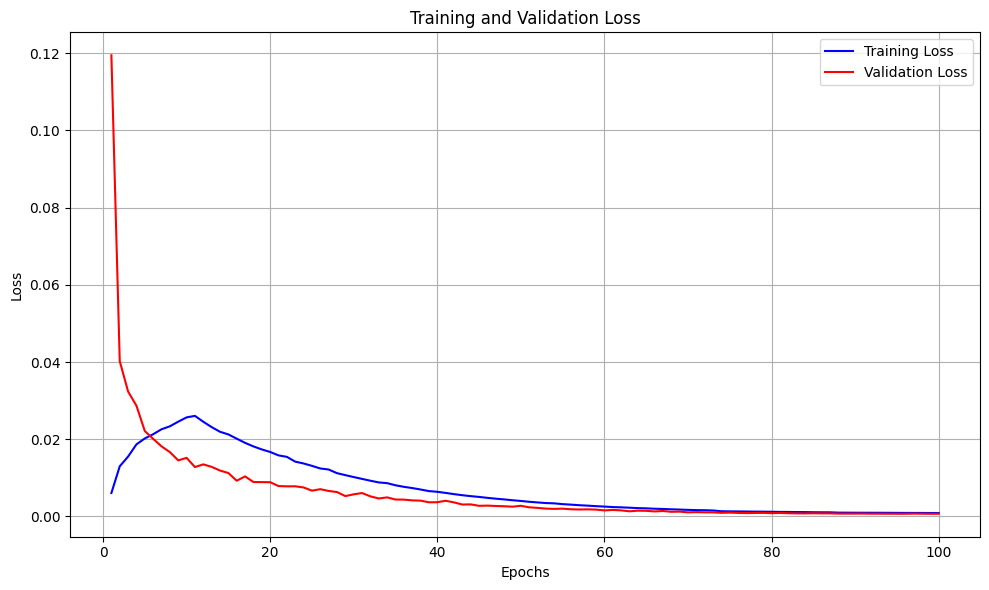

Plot saved to metrics_plot.png


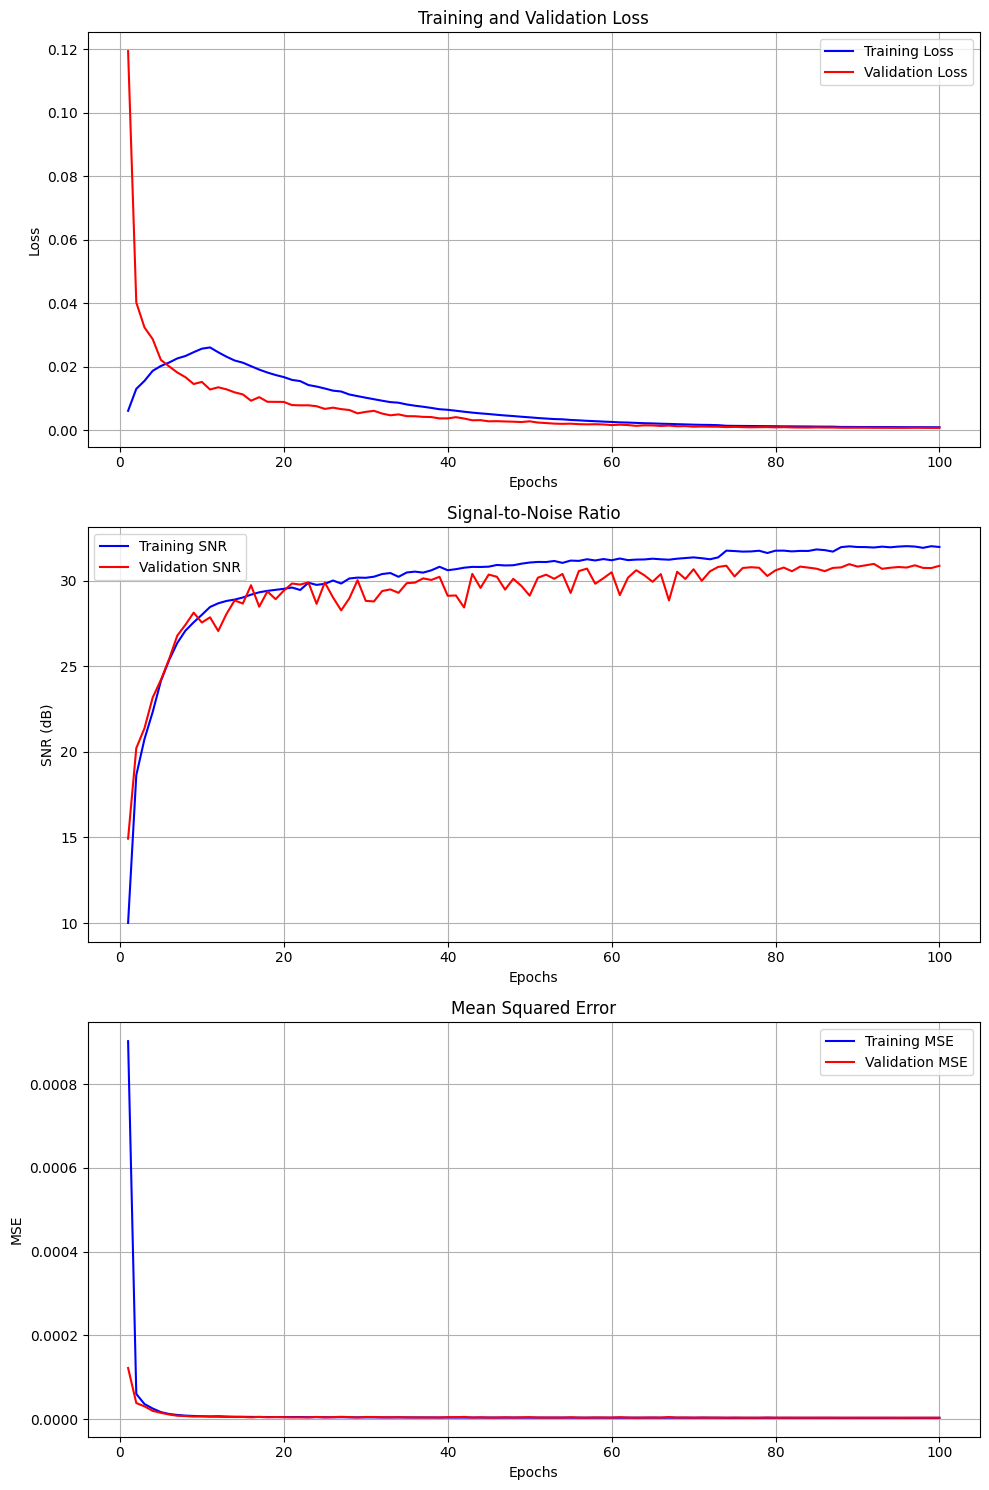

<ipython-input-28-f70445797ecd>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model metrics: SNR = 30.741336160776566dB, MSE = 3.7096095804347706e-06
Loaded model from epoch 98 with validation loss: 0.0007
Successfully saved using soundfile


In [ ]:
if __name__ == "__main__":
    # For training
    train_loader, val_loader = create_dataloaders(
        audio_dir="/content/drive/MyDrive/snare_samples/16bit_mono_wavs_clipped_44100/training",
        batch_size=8
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FrequencyAwareUpsampling().to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

    # Check specific layers
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Conv1d, nn.ConvTranspose1d)):
            print(f"{name}: requires_grad = {layer.weight.requires_grad}")

    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=100,
        device=device,
        initial_lr=0.0001
    )

    # Plot losses
    plot_losses(history, save_path='loss_plot.png')

    plot_metrics(history, save_path='metrics_plot.png')

    model = FrequencyAwareUpsampling()
    model, checkpoint, metrics = load_checkpoint(model, "checkpoints/best_model.pth")
    if metrics:
        print(f"Loaded model metrics: SNR = {metrics.get('snr', 'N/A')}dB, MSE = {metrics.get('mse', 'N/A')}")
    print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss: {checkpoint['val_loss']:.4f}")

    inference(
        model=model,
        input_file="/content/drive/MyDrive/snare_samples/16bit_mono_wavs_clipped_22050/validation/SNARE_12_LUDWIG_20s_5x14_1-PLY_10_LUG_BOTTOM_CENTER_03_1.wav",
        output_file="output.wav"
    )

## Upsample diffwave output files

In [ ]:
model = FrequencyAwareUpsampling()
model, checkpoint, metrics = load_checkpoint(model, "/content/drive/MyDrive/271_proj/audio_upsampleV2/checkpoints/best_model.pth")

# Run inference
for i in range(0,101):
  inference(
      model=model,
      input_file=f"/content/drive/MyDrive/271_proj/diffwaveOUTPUT/800_output{i}.wav",
      output_file=f"diffWave_upsample_{i}.wav"
  )

<ipython-input-11-cf8bd0fe25f4>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/usr/local/lib/python3.10/dis

Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved u

## Upsample wavegan output files

In [13]:
model = FrequencyAwareUpsampling()
model, checkpoint, metrics = load_checkpoint(model, "/content/drive/MyDrive/271_proj/audio_upsampleV2/checkpoints/best_model.pth")

# Run inference
for i in range(1,101):
  inference(
      model=model,
      input_file=f"/content/drive/MyDrive/271_proj/waveGAN_results/generated_samples/sample_{i}.wav",
      output_file=f"waveGAN_upsample_{i}.wav"
  )

<ipython-input-8-cf8bd0fe25f4>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved u

## 5 samples to test

In [11]:
model = FrequencyAwareUpsampling()
model, checkpoint, metrics = load_checkpoint(model, "/content/drive/MyDrive/271_proj/audio_upsampleV2/checkpoints/best_model.pth")

# Run inference
for i in range(1,6):
  inference(
      model=model,
      input_file=f"/content/sample{i}_lr.wav",
      output_file=f"sample{i}_upsampled.wav"
  )

<ipython-input-9-cf8bd0fe25f4>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/usr/local/lib/python3.10/dist

Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
Successfully saved using soundfile
